In [0]:

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

train_data = pd.read_excel('Data_Train.xlsx')
test_data = pd.read_excel('Data_Test.xlsx')

train_data.head(10)

print("Number of data points in train data", train_data.shape)
print('-'*50)
print("The attributes of data :", train_data.columns.values)

Number of data points in train data (7628, 2)
--------------------------------------------------
The attributes of data : ['STORY' 'SECTION']


## Text Preprocessing

In [0]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
len(stopwords)

176

In [0]:
from tqdm import tqdm
preprocessed_train_data = []
# tqdm is for printing the status bar
for sentance in tqdm(train_data['STORY'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_train_data.append(sent.lower().strip())

100%|██████████| 7628/7628 [00:02<00:00, 3335.65it/s]


In [0]:
train_data['preprocessed_STORY'] = preprocessed_train_data
train_data.drop(['STORY'], axis=1, inplace=True)

In [0]:
from tqdm import tqdm
preprocessed_test_data = []
# tqdm is for printing the status bar
for sentance in tqdm(test_data['STORY'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_test_data.append(sent.lower().strip())

100%|██████████| 2748/2748 [00:00<00:00, 3338.59it/s]


In [0]:
test_data['preprocessed_STORY'] = preprocessed_test_data
test_data.drop(['STORY'], axis=1, inplace=True)


In [0]:
train_data['preprocessed_STORY']

0       but painful huge reversal fee income unheard a...
1       how formidable opposition alliance among congr...
2       most asian currencies trading lower today sout...
3       if want answer question click answer after cli...
4       in global markets gold prices edged today disa...
5       beijing chinese tech giant huawei announced pl...
6       mumbai india inc external commercial borrowing...
7       on wednesday federal reserve chairman jerome p...
8       what give audience i already done yeh hai aash...
9       com arbaaz khan spoke getting back dabangg sal...
10      one would think development testing process wo...
11      so far year rupee gained 0 7 foreign investors...
12      xiaomi however sees presence jio rural markets...
13      the ad reads no bells whistles no bezel no not...
14      on tuesday powell said healthy us economy face...
15      this feature help make display responsive turn...
16      tiktok popular among children facing criticism...
17      the co

In [0]:
train_data.shape

(7628, 2)

In [0]:
train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

### Split dataset

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from collections import Counter
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [0]:
train_data[train_data.isnull().any(axis=1)]

,SECTION,preprocessed_STORY


In [0]:

y=train_data['SECTION']
y.shape

(7628,)

In [0]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(train_data, y, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)


In [0]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 4881
Number of data points in test data: 1526
Number of data points in cross validation data: 1221


In [0]:
train_class_distribution = train_df['SECTION'].value_counts()
type(train_class_distribution)

pandas.core.series.Series

### Distribution of y_i's in Train, Test and Cross Validation datasets

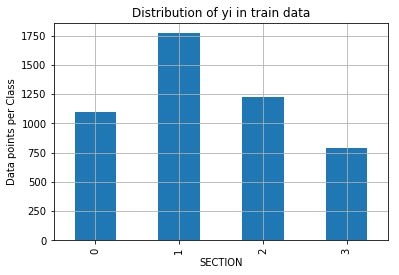

Number of data points in class 2 : 1770 ( 36.263 %)
Number of data points in class 3 : 1223 ( 25.056 %)
Number of data points in class 1 : 1099 ( 22.516 %)
Number of data points in class 4 : 789 ( 16.165 %)
--------------------------------------------------------------------------------


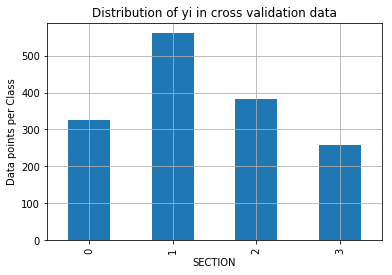

Number of data points in class 2 : 560 ( 36.697 %)
Number of data points in class 3 : 383 ( 25.098 %)
Number of data points in class 1 : 326 ( 21.363 %)
Number of data points in class 4 : 257 ( 16.841 %)
--------------------------------------------------------------------------------


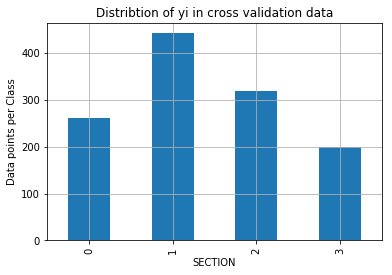

Number of data points in class 2 : 442 ( 36.2 %)
Number of data points in class 3 : 318 ( 26.044 %)
Number of data points in class 1 : 261 ( 21.376 %)
Number of data points in class 4 : 200 ( 16.38 %)


In [0]:
train_class_distribution = train_df['SECTION'].value_counts().sort_index()
test_class_distribution = test_df['SECTION'].value_counts().sort_index()
cv_class_distribution = cv_df['SECTION'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('SECTION')
plt.ylabel('Data points per Class')
plt.grid()
plt.title('Distribtion of yi in cross validation data')
plt.show()

          
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


## Univariate Analysis on Text Feature

In [0]:
train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

In [0]:
import collections
from collections import defaultdict

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['preprocessed_STORY'].split():
            dictionary[word] +=1
    return dictionary


In [0]:
import math
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],4))
    for i in range(0,3):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['preprocessed_STORY'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+40)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['preprocessed_STORY'].split()))
            row_index += 1
    return text_feature_responseCoding


In [0]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=2)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['preprocessed_STORY'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))


Total number of unique words in train data : 15417


In [0]:
dict_list = []
# dict_list =[] contains 4 dictoinaries each corresponds to a class
for i in range(0,3):
    cls_text = train_df[train_df['SECTION']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,3):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+40))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [0]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [0]:
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T


In [0]:
from sklearn.preprocessing import Normalizer
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['preprocessed_STORY'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['preprocessed_STORY'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)



In [0]:
# we use the same vectorizer that was trained on train data
data_test_text__onehotCoding = text_vectorizer.transform(test_data['preprocessed_STORY'])
# don't forget to normalize every feature
data_test__onehotCoding = normalize(data_test_text__onehotCoding, axis=0)

In [0]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))


In [0]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))


Counter({2: 3656, 3: 2096, 4: 1466, 5: 986, 6: 762, 7: 574, 8: 442, 9: 405, 10: 365, 12: 279, 11: 270, 13: 248, 14: 211, 15: 152, 16: 149, 18: 146, 17: 145, 19: 122, 20: 115, 21: 111, 22: 95, 25: 85, 24: 85, 27: 81, 23: 81, 26: 71, 30: 62, 35: 61, 29: 60, 31: 55, 28: 54, 37: 49, 32: 48, 39: 46, 38: 42, 33: 40, 34: 37, 49: 34, 47: 34, 42: 33, 36: 33, 46: 31, 41: 31, 40: 30, 48: 29, 60: 28, 56: 27, 55: 27, 54: 27, 52: 27, 50: 27, 44: 27, 45: 25, 51: 22, 43: 22, 64: 21, 61: 20, 57: 20, 68: 18, 53: 18, 76: 16, 74: 16, 67: 16, 63: 16, 71: 15, 80: 14, 73: 14, 69: 14, 58: 14, 95: 13, 93: 13, 78: 13, 65: 13, 59: 13, 106: 12, 101: 12, 81: 12, 72: 12, 66: 12, 62: 12, 104: 11, 92: 11, 79: 11, 102: 10, 90: 10, 88: 10, 87: 10, 70: 10, 136: 9, 120: 9, 100: 9, 91: 9, 84: 9, 83: 9, 77: 9, 135: 8, 115: 8, 107: 8, 89: 8, 75: 8, 194: 7, 146: 7, 142: 7, 133: 7, 125: 7, 124: 7, 118: 7, 114: 7, 98: 7, 94: 7, 86: 7, 187: 6, 128: 6, 127: 6, 119: 6, 113: 6, 109: 6, 316: 5, 237: 5, 197: 5, 190: 5, 185: 5, 181: 

For values of alpha =  1e-05 The log loss is: 0.10381013662701533
For values of alpha =  0.0001 The log loss is: 0.10183310117901978
For values of alpha =  0.001 The log loss is: 0.12266336061487551
For values of alpha =  0.01 The log loss is: 0.144729218094718
For values of alpha =  0.1 The log loss is: 0.18679217232366976
For values of alpha =  1 The log loss is: 0.20760152323442668


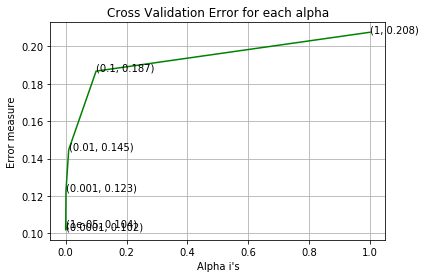

For values of best alpha =  0.0001 The train log loss is: 0.05784970269917716
For values of best alpha =  0.0001 The cross validation log loss is: 0.10183310117901978
For values of best alpha =  0.0001 The test log loss is: 0.12709069915479548


In [0]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Text feature stable across all the data sets (Test, Train, Cross validation)

In [0]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['preprocessed_STORY'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2



In [0]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")


98.255 % of word of test data appeared in train data
98.316 % of word of Cross Validation appeared in train data


## Machine Learning Models

In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Prepare final  dataset

In [0]:
train_x_onehotCoding = ((train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['SECTION']))

test_x_onehotCoding = ((test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['SECTION']))

cv_x_onehotCoding = ((cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['SECTION']))

In [0]:
train_x_responseCoding = ((train_text_feature_responseCoding))
test_x_responseCoding = ((test_text_feature_responseCoding))
cv_x_responseCoding = ((cv_text_feature_responseCoding))

In [0]:
train_data.columns

Index(['SECTION', 'preprocessed_STORY'], dtype='object')

In [0]:
train_data["SECTION"].value_counts()

1    2772
2    1924
0    1686
3    1246
Name: SECTION, dtype: int64

In [0]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    
    labels = [0,1,2,3]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


In [0]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (4881, 15417)
(number of data points * number of features) in test data =  (1526, 15417)
(number of data points * number of features) in cross validation data = (1221, 15417)


In [0]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)


 Response encoding features :
(number of data points * number of features) in train data =  (4881, 4)
(number of data points * number of features) in test data =  (1526, 4)
(number of data points * number of features) in cross validation data = (1221, 4)


## Base Line Model

## Naive Bayes

### Hyper parameter tuning

for alpha = 1e-05
Log Loss : 0.23087037425923346
for alpha = 0.0001
Log Loss : 0.21579067147420522
for alpha = 0.001
Log Loss : 0.19304661516197844
for alpha = 0.1
Log Loss : 0.14287040221242892
for alpha = 1
Log Loss : 0.12713449367369004
for alpha = 10
Log Loss : 0.12690396968489465
for alpha = 100
Log Loss : 0.1490299695712629
for alpha = 1000
Log Loss : 0.14941420387144785


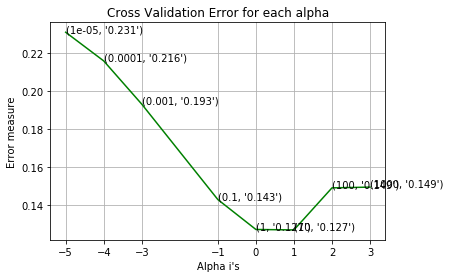

For values of best alpha =  10 The train log loss is: 0.10083464030894052
For values of best alpha =  10 The cross validation log loss is: 0.12690396968489465
For values of best alpha =  10 The test log loss is: 0.16848153585171596


In [0]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



### Testing the model with best hyper paramters

Log Loss : 0.12690396968489465
Number of missclassified point : 0.042588042588042586
-------------------- Confusion matrix --------------------


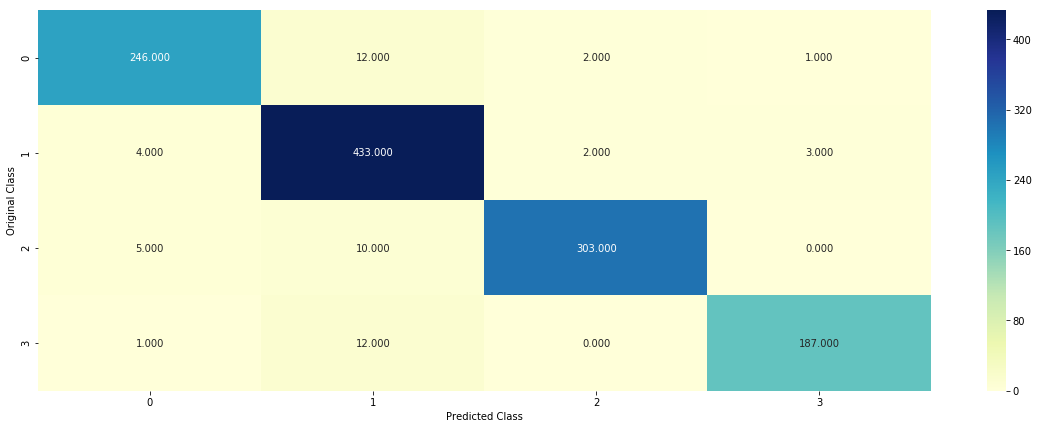

-------------------- Precision matrix (Columm Sum=1) --------------------


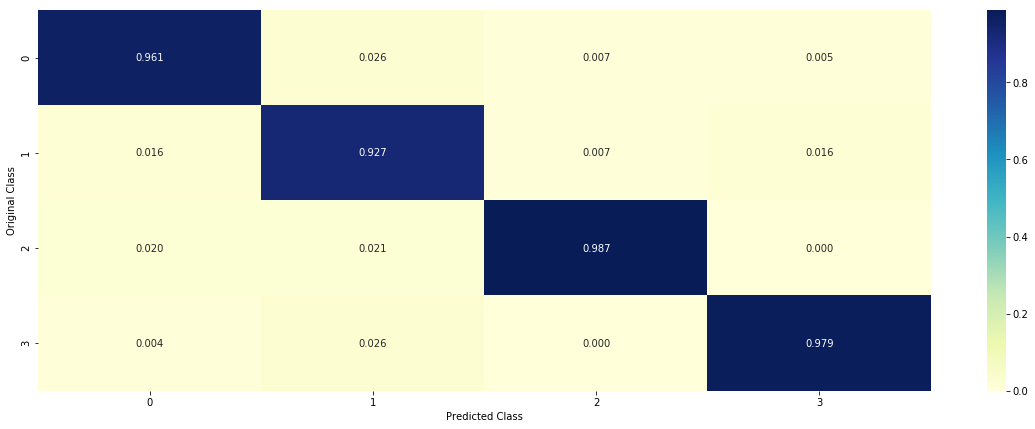

-------------------- Recall matrix (Row sum=1) --------------------


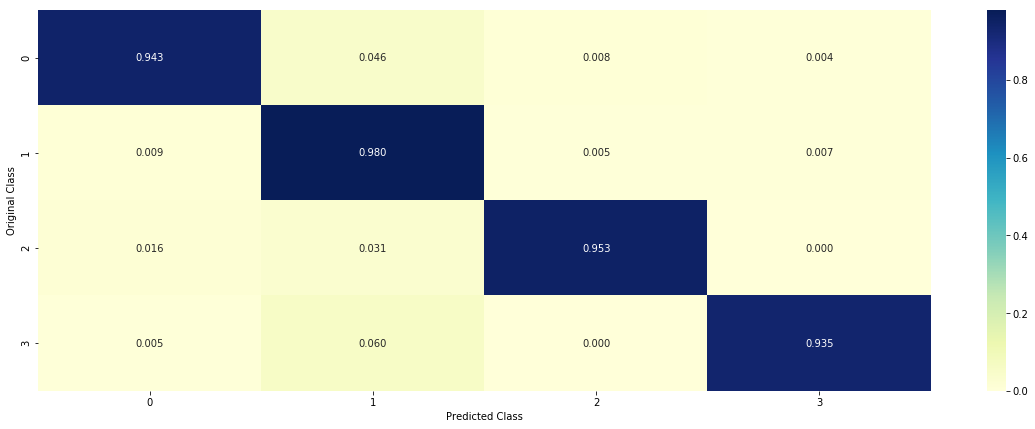

Predicted Class : 1
Predicted Class Probabilities: [[0.000e+00 9.998e-01 2.000e-04 0.000e+00]]
Actual Class : 1


In [0]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))
test_point_index = 1
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])


## K Nearest Neighbour Classification

### Hyper parameter tuning

for alpha = 5
Log Loss : 0.3385748909074906
for alpha = 11
Log Loss : 0.3297514933998
for alpha = 15
Log Loss : 0.3233251907730158
for alpha = 21
Log Loss : 0.3239700170278137
for alpha = 31
Log Loss : 0.3205568427128506
for alpha = 41
Log Loss : 0.32038099846569207
for alpha = 51
Log Loss : 0.32036119592354817
for alpha = 99
Log Loss : 0.3207494566763655


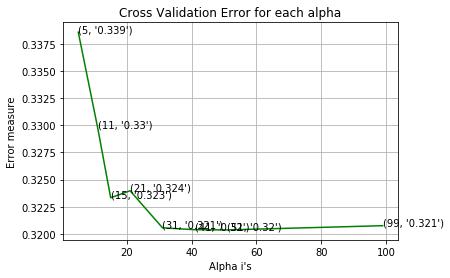

For values of best alpha =  51 The train log loss is: 0.24341335247186255
For values of best alpha =  51 The cross validation log loss is: 0.32036119592354817
For values of best alpha =  51 The test log loss is: 0.3442705914470684


In [0]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing the model with best hyper paramters

Log loss : 0.32036119592354817
Number of mis-classified points : 0.09991809991809991
-------------------- Confusion matrix --------------------


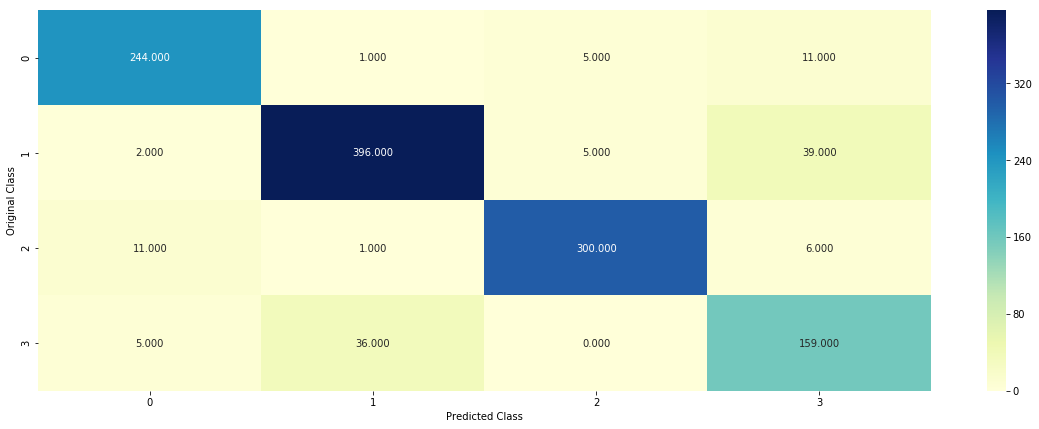

-------------------- Precision matrix (Columm Sum=1) --------------------


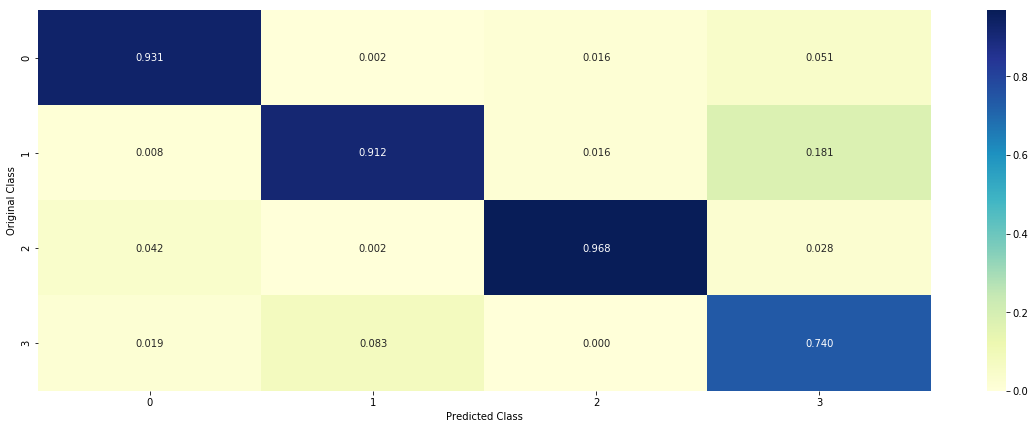

-------------------- Recall matrix (Row sum=1) --------------------


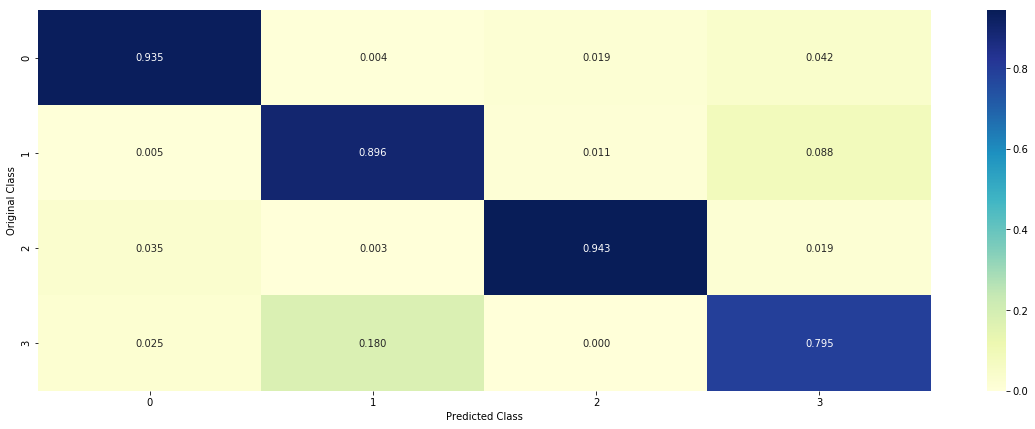

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))


Predicted Class : 0
Actual Class : 1
The  51  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Fequency of nearest points : Counter({1: 51})


In [0]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 2
Actual Class : 2
the k value for knn is 51 and the nearest neighbours of the test points belongs to classes [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Fequency of nearest points : Counter({2: 51})


## Logistic Regression(With Class balancing)

### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 0.16846803241215805
for alpha = 1e-05
Log Loss : 0.10556814141115053
for alpha = 0.0001
Log Loss : 0.10159542345757465
for alpha = 0.001
Log Loss : 0.12580715774255888
for alpha = 0.01
Log Loss : 0.1448466415913126
for alpha = 0.1
Log Loss : 0.19684764135432475
for alpha = 1
Log Loss : 0.23599355526207055
for alpha = 10
Log Loss : 0.24203215586243218
for alpha = 100
Log Loss : 0.2429843022772273


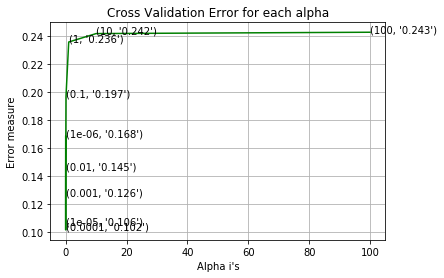

For values of best alpha =  0.0001 The train log loss is: 0.05793152032429241
For values of best alpha =  0.0001 The cross validation log loss is: 0.10159542345757465
For values of best alpha =  0.0001 The test log loss is: 0.12674522282210451


In [0]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing the model with best hyper paramters

Log loss : 0.10159542345757465
Number of mis-classified points : 0.027846027846027847
-------------------- Confusion matrix --------------------


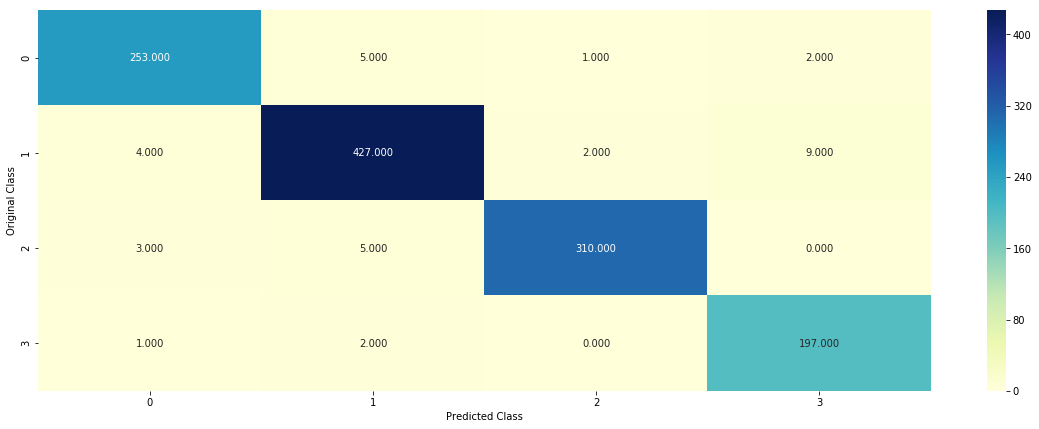

-------------------- Precision matrix (Columm Sum=1) --------------------


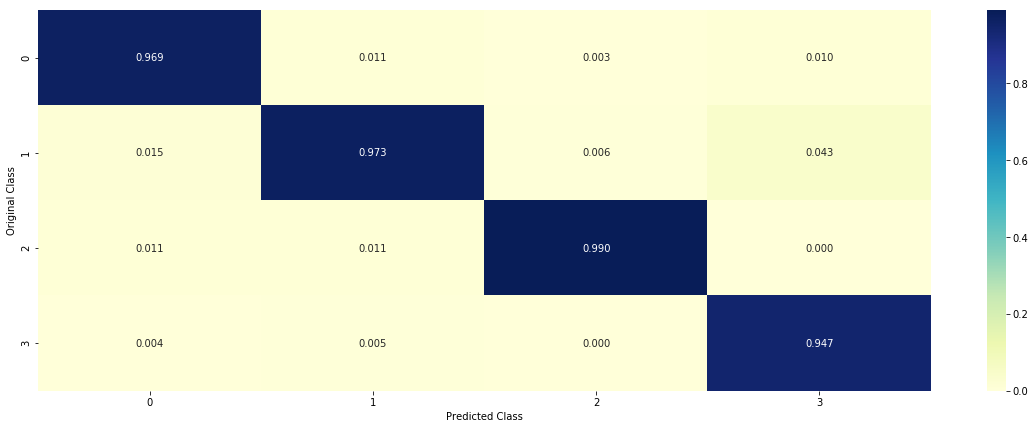

-------------------- Recall matrix (Row sum=1) --------------------


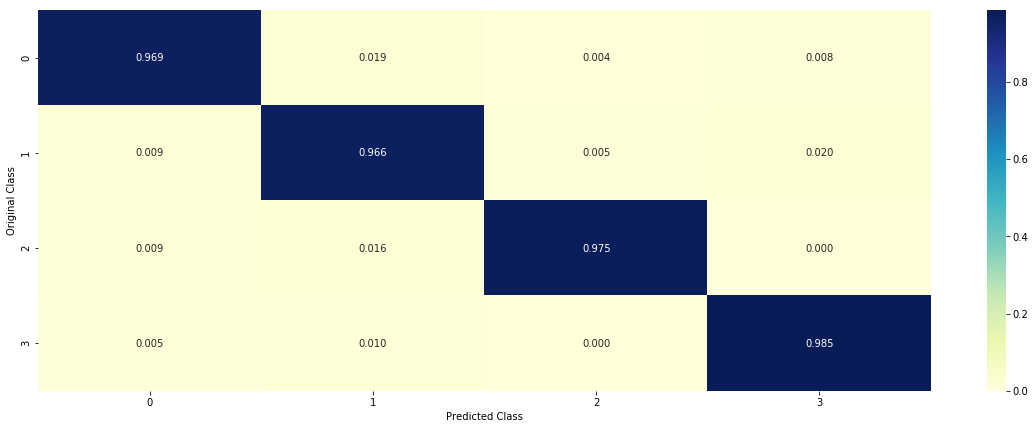

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [0]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[4.000e-04 9.994e-01 2.000e-04 1.000e-04]]
Actual Class : 1


## Logistic Regression(Without Class balancing)

### Hyper paramter tuning

for alpha = 1e-06
Log Loss : 0.163885838242956
for alpha = 1e-05
Log Loss : 0.10381013662701533
for alpha = 0.0001
Log Loss : 0.10183310117901978
for alpha = 0.001
Log Loss : 0.12266336061487551
for alpha = 0.01
Log Loss : 0.144729218094718
for alpha = 0.1
Log Loss : 0.18679217232366976
for alpha = 1
Log Loss : 0.20760152323442668


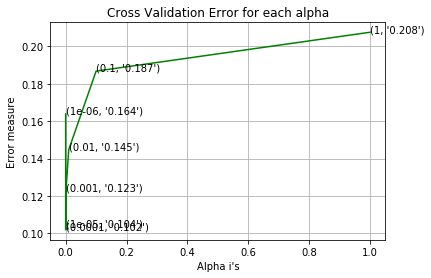

For values of best alpha =  0.0001 The train log loss is: 0.05784970269917716
For values of best alpha =  0.0001 The cross validation log loss is: 0.10183310117901978
For values of best alpha =  0.0001 The test log loss is: 0.12709069915479548


In [0]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing model with best hyper parameters

Log loss : 0.10183310117901978
Number of mis-classified points : 0.027846027846027847
-------------------- Confusion matrix --------------------


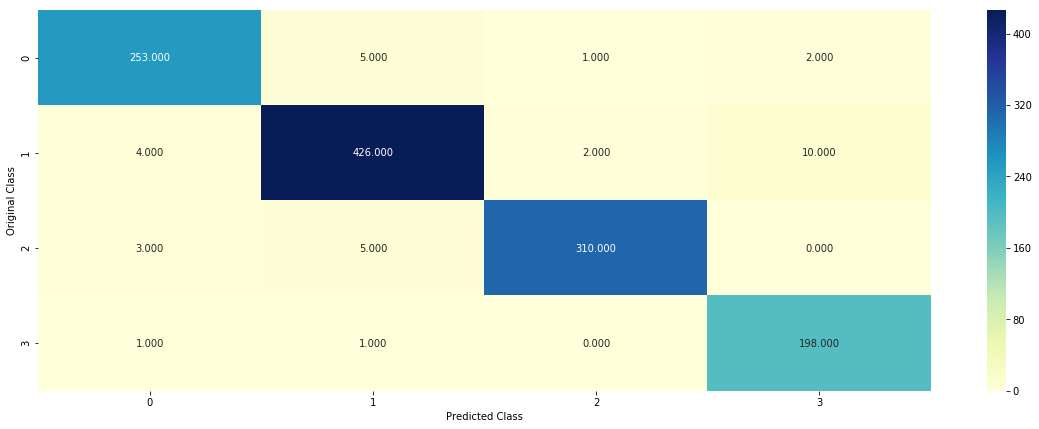

-------------------- Precision matrix (Columm Sum=1) --------------------


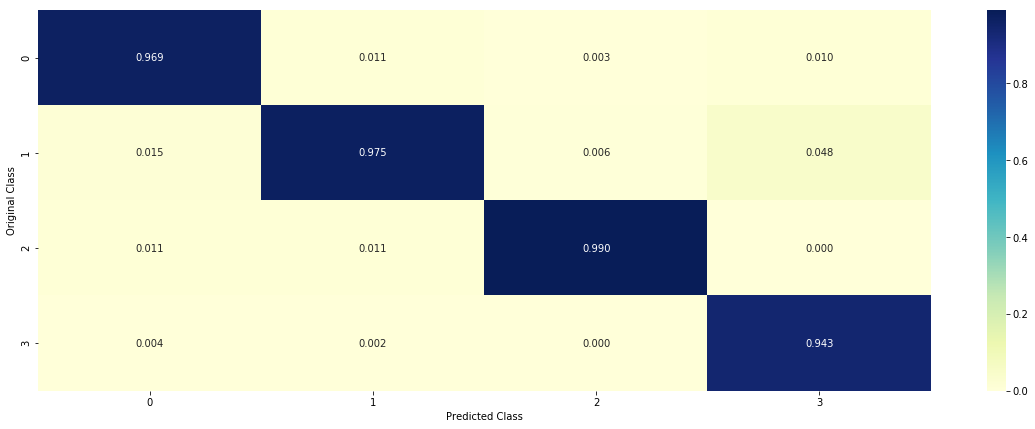

-------------------- Recall matrix (Row sum=1) --------------------


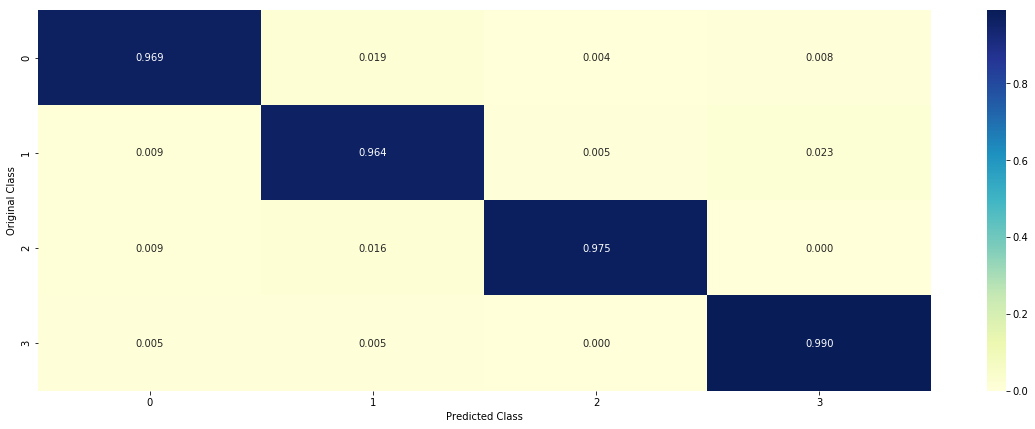

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)


In [0]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[4.000e-04 9.993e-01 2.000e-04 1.000e-04]]
Actual Class : 1


## Linear Support Vector Machines

### Hyper paramter tuning

for C = 1e-05
Log Loss : 0.14131695876851186
for C = 0.0001
Log Loss : 0.11423809105701904
for C = 0.001
Log Loss : 0.15484429209970368
for C = 0.01
Log Loss : 0.1961942527781592
for C = 0.1
Log Loss : 0.24293558962384276
for C = 1
Log Loss : 0.24350937414893764
for C = 10
Log Loss : 0.24350930738255344
for C = 100
Log Loss : 0.24350932278970186


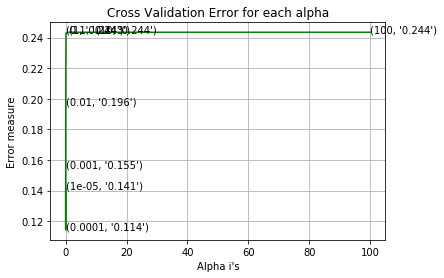

For values of best alpha =  0.0001 The train log loss is: 0.061041336486603995
For values of best alpha =  0.0001 The cross validation log loss is: 0.11423809105701904
For values of best alpha =  0.0001 The test log loss is: 0.13847626974161406


In [0]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Testing model with best hyper parameters

Log loss : 0.11423809105701904
Number of mis-classified points : 0.02620802620802621
-------------------- Confusion matrix --------------------


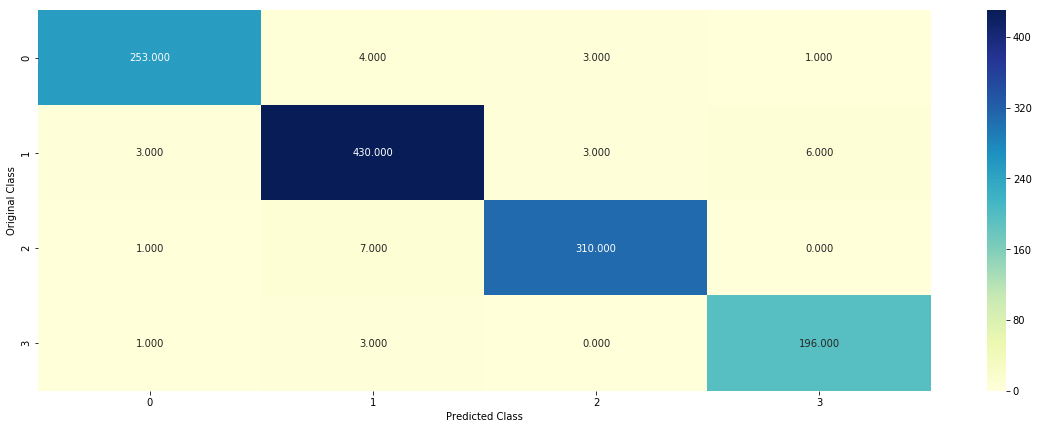

-------------------- Precision matrix (Columm Sum=1) --------------------


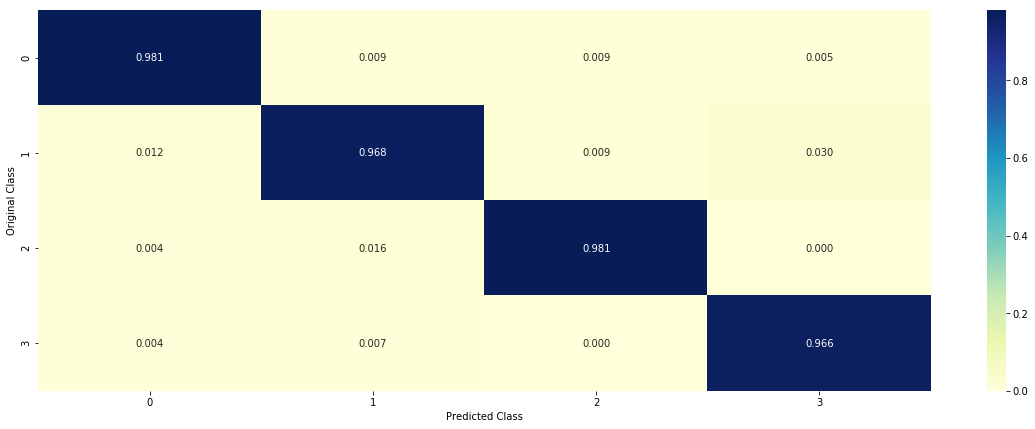

-------------------- Recall matrix (Row sum=1) --------------------


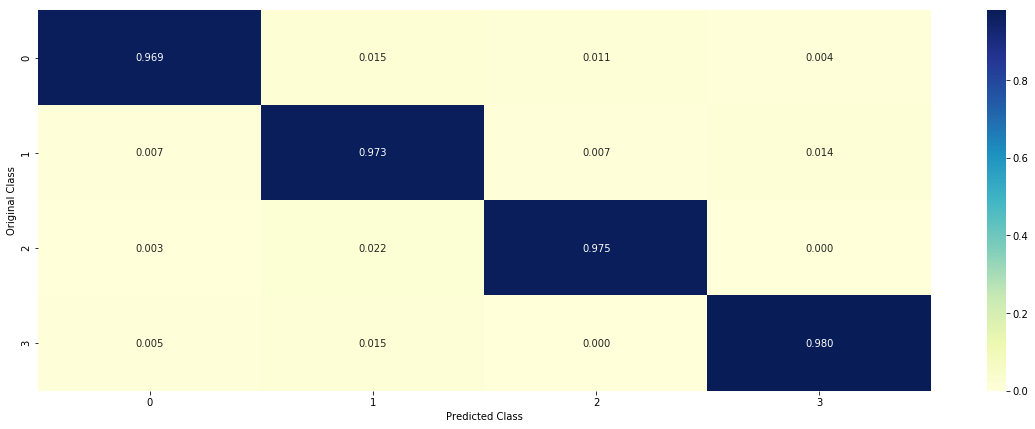

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [0]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[1.100e-03 9.974e-01 1.100e-03 4.000e-04]]
Actual Class : 1


## Random Forest Classifier(With One hot Encoding)

### Hyper paramter tuning

In [0]:
alpha = [100,200,500,1000,2000]
max_depth = [2,3,5,7,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

        
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/5)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 100 and max depth =  2
Log Loss : 0.3383635944497477
for n_estimators = 100 and max depth =  3
Log Loss : 0.29661085023671513
for n_estimators = 100 and max depth =  5
Log Loss : 0.2650465215879331
for n_estimators = 100 and max depth =  7
Log Loss : 0.2455093247146163
for n_estimators = 100 and max depth =  10
Log Loss : 0.23712491143193937
for n_estimators = 200 and max depth =  2
Log Loss : 0.2902930869162855
for n_estimators = 200 and max depth =  3
Log Loss : 0.2723225886885495
for n_estimators = 200 and max depth =  5
Log Loss : 0.24987968105851208
for n_estimators = 200 and max depth =  7
Log Loss : 0.23916511726593628
for n_estimators = 200 and max depth =  10
Log Loss : 0.22880695048532862
for n_estimators = 500 and max depth =  2
Log Loss : 0.2632698780955394
for n_estimators = 500 and max depth =  3
Log Loss : 0.2622700719788839
for n_estimators = 500 and max depth =  5
Log Loss : 0.24789302950852937
for n_estimators = 500 and max depth =  7
Log Loss : 0.2

### Testing model with best hyper parameters (One Hot Encoding)

Log loss : 0.22710001159146107
Number of mis-classified points : 0.0728910728910729
-------------------- Confusion matrix --------------------


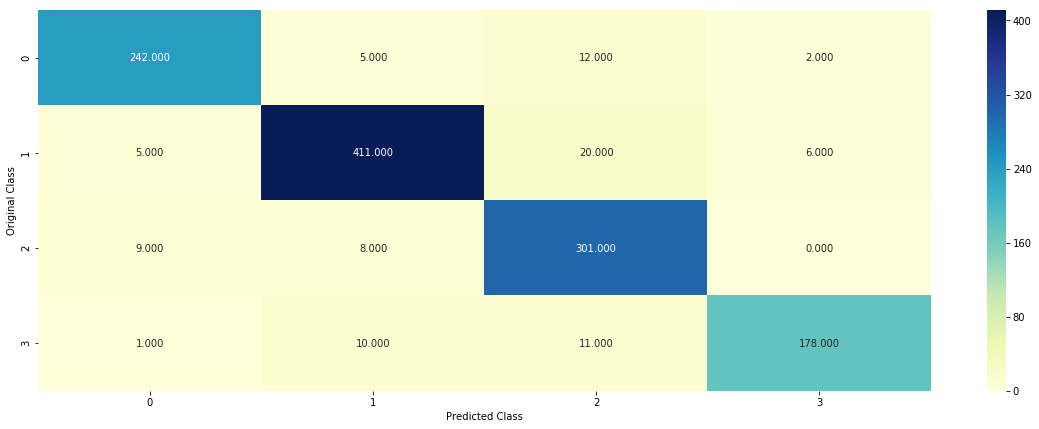

-------------------- Precision matrix (Columm Sum=1) --------------------


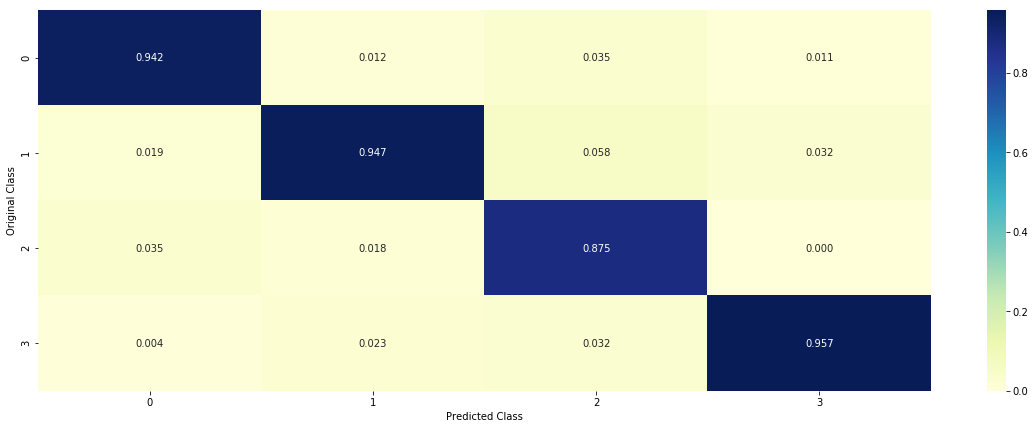

-------------------- Recall matrix (Row sum=1) --------------------


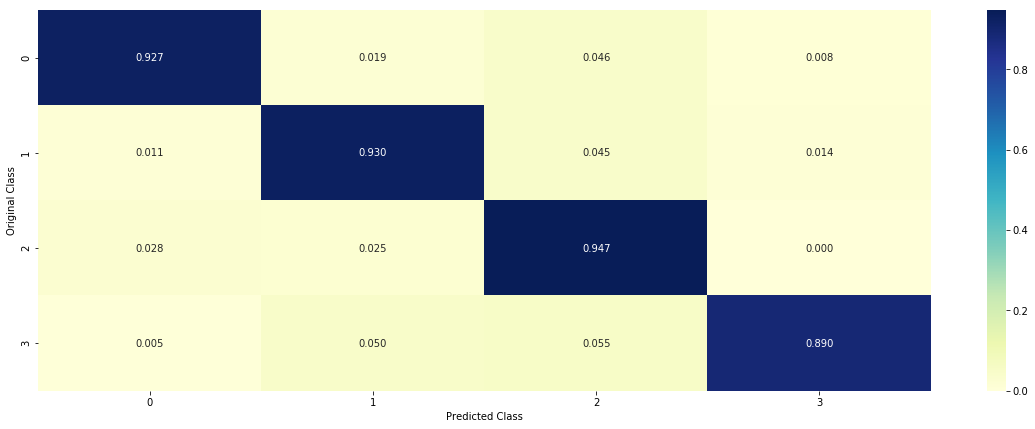

In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)


In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/5)], criterion='gini', max_depth=max_depth[int(best_alpha%5)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[6.200e-03 9.919e-01 2.000e-04 1.700e-03]]
Actual Class : 1


## Random Forest Classifier(With Response Coding)

In [0]:
alpha = [10,50,100,200,500,1000,2000]
max_depth = [2,3,5,7,10,15,20]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/7)], criterion='gini', max_depth=max_depth[int(best_alpha%7)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/7)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/7)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/7)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for n_estimators = 10 and max depth =  2
Log Loss : 0.330376769348958
for n_estimators = 10 and max depth =  3
Log Loss : 0.3266964779009474
for n_estimators = 10 and max depth =  5
Log Loss : 0.3221583601855092
for n_estimators = 10 and max depth =  7
Log Loss : 0.31751748441357824
for n_estimators = 10 and max depth =  10
Log Loss : 0.32000248034423423
for n_estimators = 10 and max depth =  15
Log Loss : 0.3221485997651517
for n_estimators = 10 and max depth =  20
Log Loss : 0.32325746635357366
for n_estimators = 50 and max depth =  2
Log Loss : 0.3396445548136813
for n_estimators = 50 and max depth =  3
Log Loss : 0.3319420243687459
for n_estimators = 50 and max depth =  5
Log Loss : 0.3238141230306295
for n_estimators = 50 and max depth =  7
Log Loss : 0.31906477348778006
for n_estimators = 50 and max depth =  10
Log Loss : 0.321434016154748
for n_estimators = 50 and max depth =  15
Log Loss : 0.3230782565955148
for n_estimators = 50 and max depth =  20
Log Loss : 0.323136515836572

### Testing model with best hyper parameters

Log loss : 0.31743591031490165
Number of mis-classified points : 0.09828009828009827
-------------------- Confusion matrix --------------------


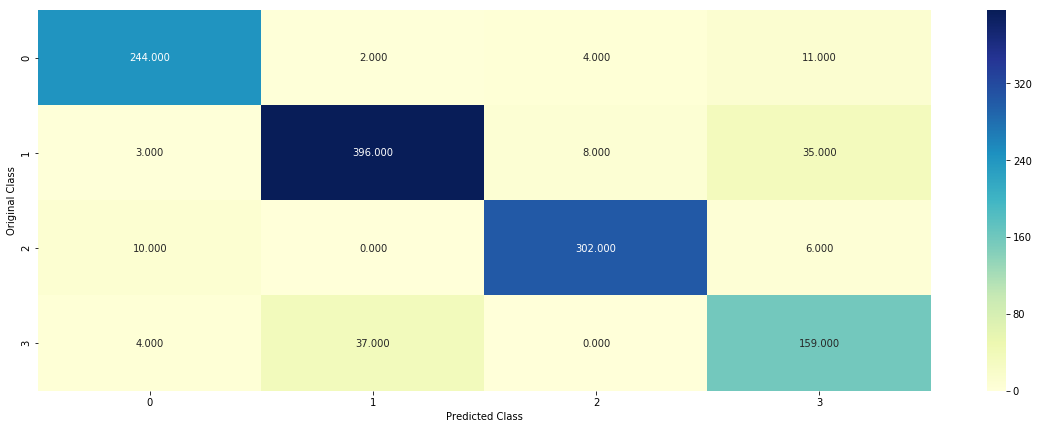

-------------------- Precision matrix (Columm Sum=1) --------------------


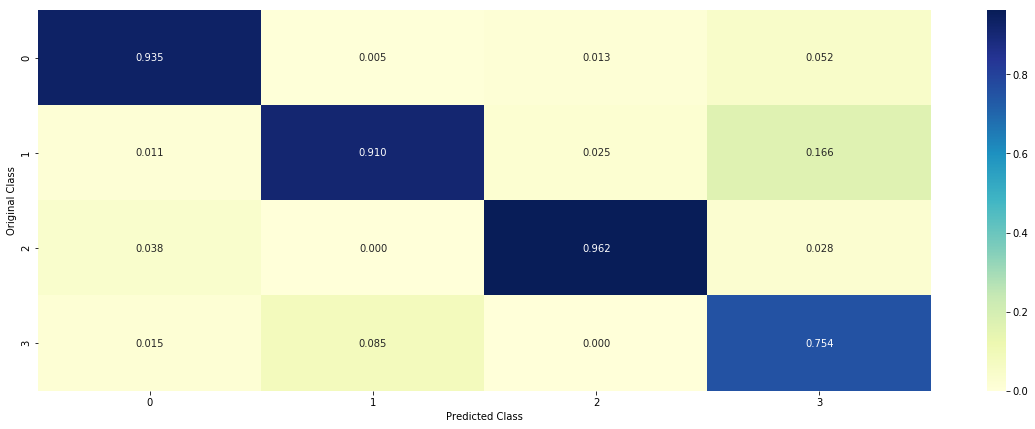

-------------------- Recall matrix (Row sum=1) --------------------


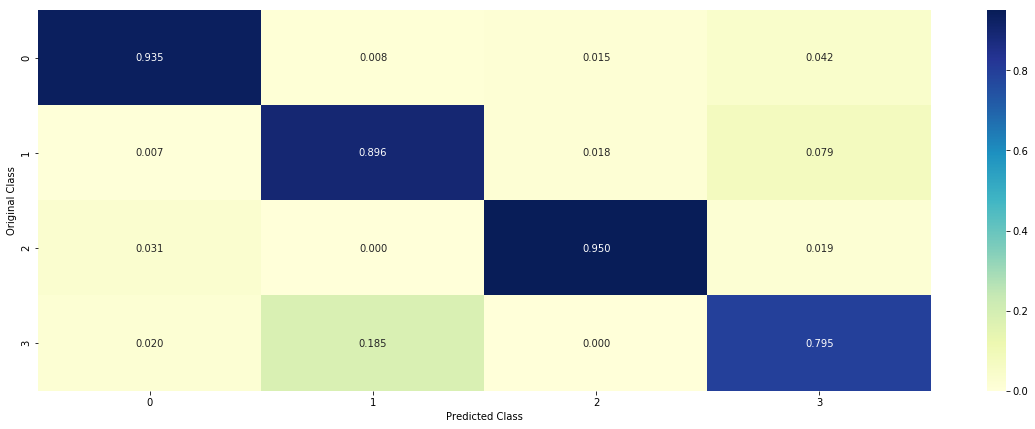

In [0]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%7)], n_estimators=alpha[int(best_alpha/7)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)


In [0]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/7)], criterion='gini', max_depth=max_depth[int(best_alpha%7)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 1
Predicted Class Probabilities: [[0.0085 0.9636 0.0088 0.0192]]
Actual Class : 1


## Stack the models

### testing with hyper parameter tuning

In [0]:
clf1 = SGDClassifier(alpha=0.0001 , penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf1.fit(train_x_onehotCoding, train_y)

clf2 = SGDClassifier(alpha=0.0001, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf2.fit(train_x_onehotCoding, train_y)


clf3 = MultinomialNB(alpha=1)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf3.fit(train_x_onehotCoding, train_y)

clf4 = RandomForestClassifier(max_depth=10, n_estimators=2000, criterion='gini', max_features='auto',random_state=42)
clf4.fit(train_x_onehotCoding, train_y)
sig_clf4 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf4.fit(train_x_onehotCoding, train_y)

clf5 = KNeighborsClassifier(n_neighbors=41)
clf5.fit(train_x_responseCoding, train_y)
sig_clf5 = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf5.fit(train_x_onehotCoding, train_y)



print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("Random forest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf4.predict_proba(cv_x_onehotCoding))))

print("K Nearest Neighbour : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf5.predict_proba(cv_x_onehotCoding))))

print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10,20,50] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.24
Support vector machines : Log Loss: 0.24
Naive Bayes : Log Loss: 0.24
Random forest : Log Loss: 0.24
K Nearest Neighbour : Log Loss: 0.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.230
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 0.694
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 0.312
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.244
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.241
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.241


### testing the model with the best hyper parameters

In [0]:
lr = LogisticRegression(C=1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3,sig_clf4,sig_clf5], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))


In [0]:
predictions = sclf.predict(data_test__onehotCoding)
print(predictions)

In [0]:
new_series = pd.Series(predictions)
new_series.value_counts()

In [0]:
train_data.head(10)

In [0]:
predictions = pd.DataFrame(new_series, columns=['SECTION'])
predictions.to_excel("News_category_submission.xlsx", index=False)


In [0]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3),('rf', sig_clf4),('knn', sig_clf5)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))